In [43]:
import os
from time import time
import inspect

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from contextlib import contextmanager

from tqdm.notebook import tqdm

import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [37]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_DIR, name))

In [2]:
INPUT_DIR = '/content/drive/MyDrive/study/table/atmacup10_dataset/'
OUTPUT_DIR = '/content/drive/MyDrive/study/table/output/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

## データ確認

In [20]:
train_df.head()

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7


In [17]:
train_df.describe()

,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
count,12016.000000,12026.000000,12016.000000,11988.000000,12026.000000
mean,1769.769724,18.112673,1769.769724,1783.393143,81.915932
std,122.237041,1.353530,122.237041,122.344180,641.094570
min,1250.000000,-2.000000,1250.000000,1250.000000,0.000000
25%,1657.750000,17.000000,1657.750000,1672.000000,0.000000
50%,1808.000000,19.000000,1808.000000,1826.000000,3.000000
75%,1872.000000,19.000000,1872.000000,1890.000000,12.000000
max,2011.000000,21.000000,2011.000000,2011.000000,27392.000000


In [18]:
test_df.describe()

,dating_sorting_date,dating_period,dating_year_early,dating_year_late
count,12000.000000,12008.000000,12000.000000,11977.000000
mean,1771.248750,18.128331,1771.248750,1785.132587
std,121.558865,1.321395,121.558865,121.664020
min,1290.000000,-2.000000,1290.000000,1290.000000
25%,1660.000000,17.000000,1660.000000,1674.000000
50%,1810.000000,19.000000,1810.000000,1830.000000
75%,1873.000000,19.000000,1873.000000,1890.000000
max,2010.000000,21.000000,2010.000000,2010.000000


In [4]:
color_df = pd.read_csv(os.path.join(INPUT_DIR, 'color.csv'))
palette_df = pd.read_csv(os.path.join(INPUT_DIR, 'palette.csv'))

In [5]:
len(list(set(color_df.object_id.tolist()) & set(palette_df.object_id.tolist())))

11499

In [15]:
len(list(set(color_df.object_id.tolist()))), len(list(set(palette_df.object_id.tolist())))

(11522, 23995)

In [12]:
len(list(set(color_df.object_id.tolist()) & set(train_df.object_id.tolist())))

5833

In [16]:
len(list(set(palette_df.object_id.tolist()) & set(train_df.object_id.tolist())))

12007

In [13]:
len(list(set(train_df.object_id.tolist())))

12026

In [19]:
# 掛け合わして使うことで、欠損値補間ができる
len(list(set(color_df.object_id.tolist()) | set(palette_df.object_id.tolist())))

24018

## 前処理

In [24]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [25]:
class NumericBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'dating_period',
            'dating_year_early',
            'dating_year_late'
        ]

        return input_df[use_columns].copy()

In [26]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

In [38]:
def read_whole_df():
    return pd.concat([
        read_csv('train'), read_csv('test')
    ], ignore_index=True)

class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
#         vc = input_df[self.column].value_counts()
        master_df = read_whole_df()
        vc = master_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [28]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count

    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories

        return self.transform(input_df)

    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [31]:
feature_blocks = [
    *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]]
]

In [32]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)

    return out_df

In [60]:
def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid), (x_train, y_train)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models


In [42]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [61]:
X_train = run_blocks(train_df, blocks=feature_blocks)
X_test = run_blocks(test_df, blocks=feature_blocks, test=True)

y = train_df['likes'].values
y = np.log1p(y)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.OneHotEncoding object at 0x7f323ef64190> 0.016[s]
	- <__main__.OneHotEncoding object at 0x7f323ef649d0> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64bd0> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64b50> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7f323ef643d0> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64150> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64f90> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64110> 0.009[s]
	- <__main__.OneHotEncoding object at 0x7f323ef640d0> 0.004[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64dd0> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64390> 0.006[s]
	- <__main__.OneHotEncoding object at 0x7f323ef645d0> 0.007[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64510> 0.008[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64950> 0.003[s]
	- <__main__.OneHotEncoding object at 0x7f323ef64d90> 0.

In [62]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(X_train, y)) # もともとが generator なため明示的に list に変換する

print(decorate('start training'))
oof, models = fit_lgbm(X_train.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.929206	valid_0's rmse: 1.14061
Early stopping, best iteration is:
[496]	training's rmse: 0.929549	valid_0's rmse: 1.14045
fit fold=0  1.700[s]
Fold 0 RMSLE: 1.1405
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.9045	valid_0's rmse: 1.15225
Early stopping, best iteration is:
[414]	training's rmse: 0.93588	valid_0's rmse: 1.14995
fit fold=1  1.569[s]
Fold 1 RMSLE: 1.1499
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.933454	valid_0's rmse: 1.11156
Early stopping, best iteration is:
[692]	training's rmse: 0.883665	valid_0's rmse: 1.10782
fit fold=2  2.183[s]
Fold 2 RMSLE: 1.1078
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.922171	valid_0's rmse: 1.14982
Early stopping, best iteration is:
[468]	training's rmse: 0.931259	vali

# 特徴量重要度

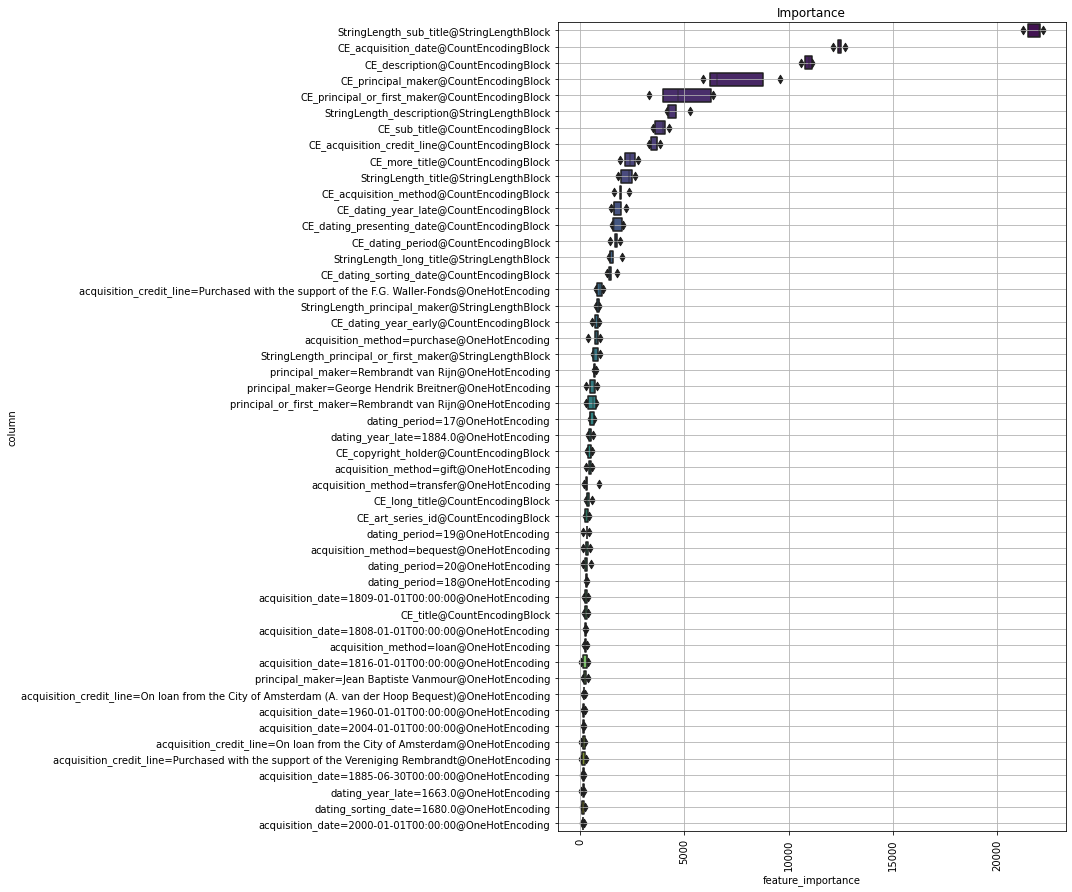

In [63]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(15, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, X_train)

## 推論

In [64]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(X_test.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, '0002__submission.csv'), index=False)

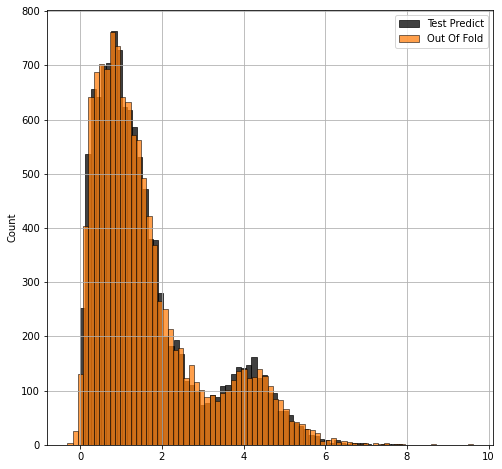

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

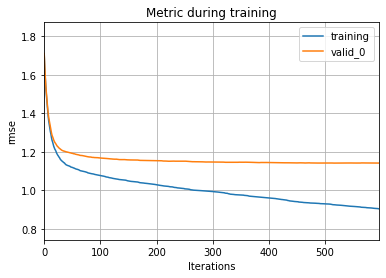

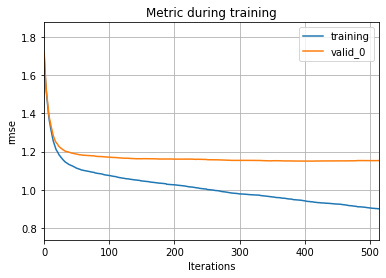

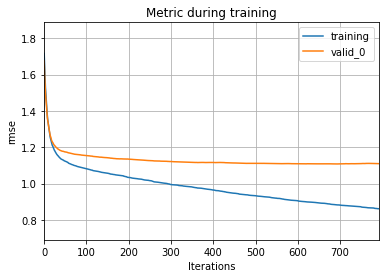

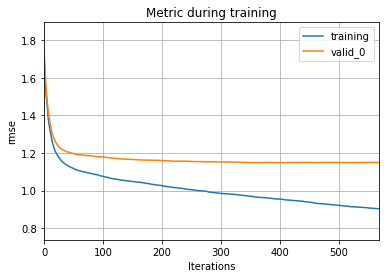

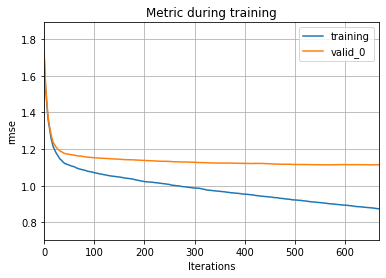

In [66]:
for model in models:
    lgbm.plot_metric(model)